# Project Navigation Guidelines

In [2]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)
'''
None

# Trial Description

In [10]:
exp = 3  #experiment number
trial = 1 #trial number
'''
Trial 1 : 
Algorithms use Vote mechanic.
Resampling done within time period of 2s.
'''
None

# Core Libraries

In [11]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Exploratory Data Analysis

# Prepare/Load Relevant Dataset

In [12]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E'+str(exp)+'_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
50620  19/3/20   15:48:23   0x0006   177    19,13
50621  19/3/20   15:48:24   0x0008   180    19,13
50622  19/3/20   15:48:24   0x0005   177    19,13
50623  19/3/20   15:48:24   0x0009   180    19,13
50624  19/3/20   15:48:24   0x0003   180    19,13

[50625 rows x 5 columns]


In [13]:
# Resample/Reshape Dataset

In [14]:
# Preparation for Date/Time Differences
# ----------------------------------------
fileNameRS = 'E'+str(exp)+'_resampled_'+'T'+str(trial)+'.csv' #resampled file name
# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]
print(readings.head(15))

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv(fileNameRS)
    print("File "+fileNameRS +" has been written.")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
50624
    DatetimeSec      ID2  RSSI Location
0       54889.0   0x0001   192      1,1
1       54889.0   0x0003   177      1,1
2       54889.0   0x0004   179      1,1
3       54890.0   0x0002   189      1,1
4       54891.0   0x0008   177      1,1
5       54891.0   0x0005   177      1,1
6       54891.0   0x0001   193      1,1
7       54891.0   0x000B   177      1,1
8       54891.0   0x0009   177      1,1
9       54891.0   0x0003   180      1,1
10      54892.0   0x0002   182      1,1
11      54893.0   0x0008   177      1,1
12      54893.0   0x0001   191      1,1
13      54893.0   0x0003   185      1,1
14      54893.0   0x000C   177      1,1
0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
50620    0.0
50621    0.0
50622    0.0
50623    0.0
50624    0.0
Name: DatetimeSec, Length: 50625, dtype: float64
File E3_resampled_T1.csv has been written.


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [26]:
resampledDS = pd.read_csv('E'+str(exp)+'_resampled_T'+str(trial)+'.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_labels = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)


# #dataset.iloc[rowrange, columnrange]
X = ips_data.to_numpy()
y = ips_labels.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True,test_size=0.3) 
y_train = y_train.reshape(len(y_train),)

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
k_value_cubeN = math.ceil(len(X_train)**(1/3))
print("k_value_rootN: ", k_value_rootN)
print("k_value_cubeN: ", k_value_cubeN)
print("X_test: ", X_test)
print("y_test: ", y_test)

k_value_rootN:  62
k_value_cubeN:  16
X_test:  [[  0. 177. 178. ... 177. 177. 177.]
 [  0. 177.   0. ...   0. 179. 192.]
 [  0. 178. 177. ...   0. 186. 191.]
 ...
 [  0.   0.   0. ... 194. 192. 191.]
 [  0. 177.   0. ... 177. 189. 198.]
 [184. 185. 190. ... 177. 180. 181.]]
y_test:  [['7,1']
 ['13,13']
 ['13,13']
 ...
 ['19,1']
 ['19,13']
 ['1,13']]


# KNN Algorithm

In [17]:
n_samples = 20

#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

In [18]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [19]:
# TEST OUTPUT

outArray = []
for i in range(n_samples):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[179.0, 183.0, 193.0, 177.0, 0.0, 179.0, 177.0...","[1,13]","[([179.0, 183.0, 193.0, 177.0, 0.0, 179.0, 177..."
1,1,"[0.0, 184.0, 193.0, 177.0, 0.0, 180.0, 177.0, ...","[1,13]","[([0.0, 177.0, 177.0, 190.0, 0.0, 179.0, 190.0..."
2,2,"[0.0, 0.0, 183.0, 188.0, 194.0, 183.0, 179.0, ...","[7,7]","[([0.0, 0.0, 185.0, 184.0, 177.0, 177.0, 178.0..."
3,3,"[0.0, 177.0, 177.0, 177.0, 0.0, 183.0, 177.0, ...","[19,13]","[([0.0, 177.0, 177.0, 177.0, 0.0, 181.0, 177.0..."
4,4,"[178.0, 193.0, 187.0, 0.0, 0.0, 194.0, 0.0, 18...","[7,13]","[([177.0, 192.0, 187.0, 0.0, 0.0, 194.0, 0.0, ..."


In [20]:
from collections import Counter

#Function enables voting mechanic in KNN for Classification according to majority class vote
def vote(neighbors):
    class_counter = Counter() #A Counter is a dict subclass for counting hashable objects. 
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #neighbor[2] -> label for neighbor(s)
    return class_counter.most_common(1)[0][0]

In [21]:
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    print("index: ", i, 
          ", result of vote: ", vote(neighbors), 
          ", label: ", y_train[i], 
          ", data: ", X_train[i])

index:  0 , result of vote:  1,13 , label:  19,7 , data:  [  0.   0. 178. 177. 178. 183. 184. 192.   0. 184. 195. 194.]
index:  1 , result of vote:  19,13 , label:  7,1 , data:  [177.   0. 181. 193.   0. 177. 180. 177. 181. 177. 183. 181.]
index:  2 , result of vote:  13,7 , label:  1,7 , data:  [181. 192. 190. 178. 185. 177. 177. 180. 177. 177. 177.   0.]
index:  3 , result of vote:  19,13 , label:  7,1 , data:  [185. 184. 181. 196. 189.   0. 184. 182. 177.   0. 184. 177.]
index:  4 , result of vote:  7,13 , label:  13,7 , data:  [177.   0. 177. 183.   0. 177. 190. 193. 191.   0. 190. 187.]


In [12]:
#Function returns vote 'probability' - i.e. distribution/percentage majority vote
def vote_prob(neighbors):
    class_counter = Counter() # Counter object - https://docs.python.org/2/library/collections.html
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1 #add to count of target (class)
        
    # aggregates into tuples ~ zip(*iterables), 
    # Return a list of the n most common elements and their counts from the most common to the least.    
    labels, votes = zip(*class_counter.most_common()) #returns list of sorted most common [labels], [votes]
    #print("L|V: ", labels, votes)
    #print("Class Counter: ", class_counter.most_common)
    winner = class_counter.most_common(1)[0][0]       #majority label
    votes4winner = class_counter.most_common(1)[0][1] #majority vote count
    return winner, votes4winner/sum(votes)            #returns majority label, majority proportion

In [31]:
k_value_knn = k_value_cubeN
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'vote_result', 'vote_prob', 'label', 'prediction'])

indexArray = []
dataArray = []
voteArray = []
probArray = []
labelArray = []
predArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    indexArray.append(i)
    dataArray.append(X_test[i])
    voteRes = vote(neighbors)
    voteArray.append(voteRes)
    probArray.append(voteRes)
    labelArray.append(y_test[i][0])
    predArray.append("CORRECT" if (voteRes == y_test[i]) else "WRONG")
#     print("index: ", i, 
#           ", result of vote: ", vote(neighbors), 
#           ", vote_prob: ", vote_prob(neighbors), 
#           ", label: ", y_test[i], "prediction: "
#         "CORRECT" if (vote(neighbors) == y_test[i]) else "WRONG"
#           ", data: ", X_test[i])

resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['vote_result'] = voteArray
resultsKNN['vote_prob'] = probArray
resultsKNN['label'] = labelArray 
resultsKNN['prediction'] = predArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E3_KNN_T1_k16.csv has been written.


,index,data,vote_result,vote_prob,label,prediction
0,0,"[0.0, 177.0, 178.0, 193.0, 182.0, 183.0, 182.0...","7,1","7,1","7,1",CORRECT
1,1,"[0.0, 177.0, 0.0, 182.0, 178.0, 188.0, 177.0, ...","13,7","13,7","13,13",WRONG
2,2,"[0.0, 178.0, 177.0, 0.0, 179.0, 185.0, 177.0, ...","13,13","13,13","13,13",CORRECT
3,3,"[0.0, 0.0, 177.0, 0.0, 0.0, 180.0, 179.0, 179....","19,13","19,13","19,13",CORRECT
4,4,"[0.0, 177.0, 178.0, 177.0, 177.0, 178.0, 179.0...","13,1","13,1","19,13",WRONG
5,5,"[193.0, 192.0, 184.0, 184.0, 180.0, 0.0, 177.0...","1,1","1,1","1,1",CORRECT
6,6,"[0.0, 0.0, 0.0, 181.0, 0.0, 177.0, 189.0, 177....","19,1","19,1","19,1",CORRECT
7,7,"[177.0, 196.0, 191.0, 177.0, 182.0, 190.0, 0.0...","1,7","1,7","1,7",CORRECT
8,8,"[177.0, 0.0, 182.0, 193.0, 0.0, 0.0, 181.0, 17...","7,1","7,1","7,1",CORRECT
9,9,"[177.0, 177.0, 181.0, 0.0, 0.0, 177.0, 181.0, ...","7,7","7,7","7,1",WRONG


# Rank (Harmonic) Weighted KNN

In [29]:
#Function for weighted KNN voting mechanic; harmonic weights based on ranking of datapoint (vote += 1/rank)
def vote_harmonic_weights(neighbors, all_results=True):
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
#         print("Index: ", index)
        class_counter[neighbors[index][2]]
#         print("Location: ", neighbors[index][2])
        class_counter[neighbors[index][2]] += ( 1/(index+1) ) #add (1/ neighbour_rank) for each vote, index+1 = neighbour_rank
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if all_results:
        total = sum(class_counter.values(), 0.0)
        for key in class_counter:
             class_counter[key] /= total #returns vote proportion for key ("class") in class_counter
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [30]:
k_value_rwknn = k_value_cubeN
writeRWKNN = True
fileNameRWKNN = 'E'+str(exp)+'_RWKNN_'+'T'+str(trial)+'_k'+str(k_value_rwknn)+'.csv'
resultsRWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rwknn, 
                              distance=euclideanDistance)
    voteResult = (vote_harmonic_weights(neighbors,all_results=True))

    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteArray.append(voteResult)
    predArray.append("CORRECT" if (voteResult[0] == y_test[i]) else "WRONG")
    
resultsRWKNN['index'] = indexArray
resultsRWKNN['data'] = dataArray
resultsRWKNN['label'] = labelArray
resultsRWKNN['vote_result'] = voteArray
resultsRWKNN['prediction'] = predArray

if (writeRWKNN == True):
    resultsRWKNN.to_csv(fileNameRWKNN, index=False)
    print("File "+fileNameRWKNN+" has been written.")
resultsRWKNN


File E3_RWKNN_T1_k16.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[0.0, 177.0, 178.0, 193.0, 182.0, 183.0, 182.0...","[7,1]","(7,1, [(7,1, 1.0)])",CORRECT
1,1,"[0.0, 177.0, 0.0, 182.0, 178.0, 188.0, 177.0, ...","[13,13]","(13,13, [(13,13, 0.35512909804359344), (13,7, ...",CORRECT
2,2,"[0.0, 178.0, 177.0, 0.0, 179.0, 185.0, 177.0, ...","[13,13]","(13,13, [(13,13, 0.9160155777061011), (19,13, ...",CORRECT
3,3,"[0.0, 0.0, 177.0, 0.0, 0.0, 180.0, 179.0, 179....","[19,13]","(19,13, [(19,13, 0.9328774718773483), (13,13, ...",CORRECT
4,4,"[0.0, 177.0, 178.0, 177.0, 177.0, 178.0, 179.0...","[19,13]","(13,1, [(13,1, 0.3126893295011531), (13,13, 0....",WRONG
...,...,...,...,...,...
1619,1619,"[178.5, 0.0, 193.0, 177.0, 177.0, 179.0, 177.0...","[1,13]","(1,13, [(1,13, 0.8794414582203838), (7,7, 0.05...",CORRECT
1620,1620,"[0.0, 0.0, 0.0, 178.0, 177.0, 177.0, 186.0, 17...","[19,1]","(19,1, [(19,1, 1.0)])",CORRECT
1621,1621,"[0.0, 0.0, 0.0, 0.0, 0.0, 177.0, 190.0, 0.0, 1...","[19,1]","(19,1, [(19,1, 0.5574311970282682), (19,13, 0....",CORRECT
1622,1622,"[0.0, 177.0, 0.0, 0.0, 0.0, 181.0, 177.0, 179....","[19,13]","(19,13, [(19,13, 0.582190704185698), (13,13, 0...",CORRECT


# Distance Weighted KNN

In [22]:
#Function for distance weighted KNN voting mechanic; weight based on euclidean distance (vote += 1/distance)
def vote_distance_weights(neighbors, all_results=True):
    debug = False
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        dist = neighbors[index][1]
        label = neighbors[index][2]
        if (debug == True):
            print("Neighbour record: Label is ", label, "with distance ", dist)
            print("Existing count for ", label, "is ", class_counter[label[0]])
            print("Adding count by ", (1 / (dist + 0.01)) )
        class_counter[label] += (1 / (dist + 0.01)) #sensitivity of distance weight can be adjusted here.
        
        
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if (debug == True):
        print("COUNTER: ", class_counter)
        print("----------------------------------------------------")
        print("winner: ", winner)
        print("votes: ", votes4winner)
    
    if all_results:
        total = sum(class_counter.values(), 0.0)
        
        for key in class_counter:
            class_counter[key] /= total
        if (debug == True):
            print("total votes: ", total)
            print("AFTER NORMALISING: ", class_counter)
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [23]:
k_value_dwknn = k_value_rootN
testRange = 200
for i in range(testRange):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    res = vote_distance_weights(neighbors, all_results=True)
    print("index: ", i, 
      ", result of vote: ", res,
    ",label: ", y_test[i], 
    ",prediction: ",
    "CORRECT" if ( res[0] == y_test[i]) else "WRONG")
    print("\n\n")

index:  0 , result of vote:  ('1,13', [('1,13', 0.9992327869402198), ('1,1', 0.0005583629803443198), ('7,1', 0.0001042691068891129), ('1,7', 5.232378417737413e-05), ('7,7', 5.225718836944742e-05)]) ,label:  ['1,13'] ,prediction:  CORRECT



index:  1 , result of vote:  ('19,13', [('19,13', 0.4144799010180749), ('13,1', 0.1431982485177867), ('19,7', 0.12439489583864419), ('7,1', 0.11291123578907036), ('1,7', 0.10305573733320728), ('7,7', 0.05090334715877348), ('13,7', 0.030418005259420258), ('7,13', 0.010359726694502535), ('13,13', 0.010278902390520143)]) ,label:  ['1,13'] ,prediction:  WRONG



index:  2 , result of vote:  ('19,13', [('19,13', 0.1907994289602142), ('13,7', 0.17906190989555254), ('19,7', 0.1498082361420375), ('13,1', 0.12773247886710357), ('13,13', 0.12509445302630612), ('1,1', 0.12016625343833187), ('7,1', 0.07377967074221486), ('7,7', 0.026867665543800684), ('7,13', 0.00668990338443872)]) ,label:  ['7,7'] ,prediction:  WRONG



index:  3 , result of vote:  ('19,13', [

index:  34 , result of vote:  ('13,1', [('13,1', 0.7872239428063033), ('19,1', 0.12672211083801485), ('19,7', 0.035631485913164236), ('13,7', 0.03040257749556103), ('7,1', 0.02001988294695667)]) ,label:  ['13,1'] ,prediction:  CORRECT



index:  35 , result of vote:  ('7,1', [('7,1', 0.7514430367276942), ('7,7', 0.20028258991328857), ('1,1', 0.032273937941372774), ('13,7', 0.016000435417644492)]) ,label:  ['7,1'] ,prediction:  CORRECT



index:  36 , result of vote:  ('1,1', [('1,1', 0.9950181096808609), ('7,7', 0.002503566873896997), ('1,7', 0.0012465303622236266), ('7,1', 0.0012317930830185464)]) ,label:  ['1,1'] ,prediction:  CORRECT



index:  37 , result of vote:  ('19,1', [('19,1', 0.6257042710852848), ('13,1', 0.293294891708212), ('19,7', 0.0810008372065033)]) ,label:  ['13,1'] ,prediction:  WRONG



index:  38 , result of vote:  ('7,1', [('7,1', 0.6122138803550731), ('13,1', 0.20817677625796238), ('13,7', 0.08925555678437985), ('19,13', 0.034663250831467304), ('19,7', 0.0260829

index:  70 , result of vote:  ('19,1', [('19,1', 0.9834673270607107), ('13,1', 0.007326275073564201), ('19,7', 0.0068885472375392895), ('19,13', 0.002317850628185731)]) ,label:  ['19,1'] ,prediction:  CORRECT



index:  71 , result of vote:  ('13,13', [('13,13', 0.5737454370690531), ('19,13', 0.3311909652477707), ('1,13', 0.035762023050184166), ('7,7', 0.023082635329727996), ('13,7', 0.018153116647582113), ('1,7', 0.009080461454193871), ('7,13', 0.004714005103154644), ('7,1', 0.004271356098333469)]) ,label:  ['13,13'] ,prediction:  CORRECT



index:  72 , result of vote:  ('19,1', [('19,1', 0.6458594361534244), ('19,13', 0.1598289248917595), ('19,7', 0.13943229787769051), ('13,1', 0.05487934107712552)]) ,label:  ['19,1'] ,prediction:  CORRECT



index:  73 , result of vote:  ('1,7', [('1,7', 0.6610314944095984), ('7,1', 0.13501807406662888), ('7,7', 0.12363413388078674), ('13,13', 0.04232823445029609), ('7,13', 0.0342604557190291), ('1,1', 0.0037276074736608423)]) ,label:  ['1,7'] ,pre

index:  102 , result of vote:  ('1,1', [('1,1', 0.8544239926176803), ('7,1', 0.0677118212531703), ('7,7', 0.02064671063762821), ('1,7', 0.015960937227194768), ('7,13', 0.015724226912394487), ('13,7', 0.014832034160679101), ('1,13', 0.01070027719125269)]) ,label:  ['1,1'] ,prediction:  CORRECT



index:  103 , result of vote:  ('13,13', [('13,13', 0.8701965800062561), ('13,1', 0.041376731207214586), ('19,1', 0.034988669687211066), ('19,7', 0.02887223850522068), ('13,7', 0.01886484113082645), ('7,1', 0.0057009394632710495)]) ,label:  ['13,13'] ,prediction:  CORRECT



index:  104 , result of vote:  ('7,7', [('7,7', 0.8023025206034969), ('7,1', 0.13180591168649552), ('7,13', 0.0542643731925504), ('1,7', 0.011627194517457109)]) ,label:  ['7,7'] ,prediction:  CORRECT



index:  105 , result of vote:  ('13,13', [('13,13', 0.9393531386817859), ('13,1', 0.02577725124278921), ('13,7', 0.011449723395913589), ('19,1', 0.009936394655544198), ('19,7', 0.008756467160283114), ('19,13', 0.004727024863

index:  134 , result of vote:  ('1,13', [('1,13', 0.9599763179708423), ('1,7', 0.01880992087236017), ('7,7', 0.009428183564659305), ('7,1', 0.004727036044797002), ('1,1', 0.004693646078946482), ('7,13', 0.002364895468394873)]) ,label:  ['1,13'] ,prediction:  CORRECT



index:  135 , result of vote:  ('19,1', [('19,1', 0.628893881829537), ('19,7', 0.2571189618268899), ('13,1', 0.06311275724430211), ('13,13', 0.050874399099270995)]) ,label:  ['19,7'] ,prediction:  WRONG



index:  136 , result of vote:  ('7,1', [('7,1', 0.2790596452923116), ('13,7', 0.22108215308168716), ('13,1', 0.2147387112597014), ('19,7', 0.10606904617524507), ('19,13', 0.09851978688630157), ('1,7', 0.044277878322693566), ('13,13', 0.014583295952039563), ('19,1', 0.014432836069470234), ('7,13', 0.007236646960550016)]) ,label:  ['13,13'] ,prediction:  WRONG



index:  137 , result of vote:  ('19,13', [('19,13', 0.39906917422617105), ('19,7', 0.36392624952089836), ('13,7', 0.11852006604194962), ('13,13', 0.093233628796

index:  165 , result of vote:  ('1,1', [('1,1', 0.41741561285833306), ('7,1', 0.19621277847116864), ('13,1', 0.11572198044516996), ('1,13', 0.07322079778263942), ('7,7', 0.0670351798619419), ('19,7', 0.04998700086856437), ('7,13', 0.032785528737191386), ('1,7', 0.030997872731157505), ('13,13', 0.01662324824383374)]) ,label:  ['1,1'] ,prediction:  CORRECT



index:  166 , result of vote:  ('7,1', [('7,1', 0.7982725548526051), ('7,7', 0.1885981531821633), ('1,7', 0.01312929196523162)]) ,label:  ['7,1'] ,prediction:  CORRECT



index:  167 , result of vote:  ('13,1', [('13,1', 0.484814556392039), ('13,7', 0.4228694058530601), ('7,1', 0.09231603775490088)]) ,label:  ['13,1'] ,prediction:  CORRECT



index:  168 , result of vote:  ('7,7', [('7,7', 0.7312786196945134), ('7,1', 0.16293669443390718), ('7,13', 0.05595084111608512), ('1,7', 0.049833844755494405)]) ,label:  ['7,7'] ,prediction:  CORRECT



index:  169 , result of vote:  ('7,13', [('7,13', 0.47259103578429745), ('1,7', 0.168377769

index:  199 , result of vote:  ('19,13', [('19,13', 0.3547256126366218), ('13,13', 0.17723591998068355), ('13,1', 0.12779533048034153), ('13,7', 0.11472483763722803), ('19,7', 0.07851812023027963), ('19,1', 0.04960621814870029), ('1,1', 0.04673798127961711), ('1,13', 0.03345415662984141), ('7,13', 0.017201822976686657)]) ,label:  ['13,1'] ,prediction:  WRONG





In [27]:
k_value_dwknn = k_value_cubeN
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'label', 'vote_result', 'prediction'])

indexArray = []
dataArray = []
labelArray = []
voteArray = []
predArray = []

# need to normalise distance!!!!

for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    voteRes = vote_distance_weights(neighbors, all_results=True)
    indexArray.append(i)
    dataArray.append(X_test[i])
    labelArray.append(y_test[i])
    voteArray.append(voteRes[0])
    predArray.append("CORRECT" if (voteRes[0] == y_test[i]) else "WRONG")

#     print("index: ", i, ", result of vote: ", vote_distance_weights(neighbors,
#                                                       all_results=True),
#         ",label: ", y_test[i], 
#         ",prediction: ",
#         "CORRECT" if ( vote_distance_weights(neighbors,
#                                 all_results=True)[0] == y_test[i]) else "WRONG")
    
resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['label'] = labelArray
resultsDWKNN['vote_result'] = voteArray
resultsDWKNN['prediction'] = predArray


if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
resultsDWKNN



File E3_DWKNN_T1_k16.csv has been written.


,index,data,label,vote_result,prediction
0,0,"[0.0, 177.0, 178.0, 193.0, 182.0, 183.0, 182.0...","[7,1]","7,1",CORRECT
1,1,"[0.0, 177.0, 0.0, 182.0, 178.0, 188.0, 177.0, ...","[13,13]","13,7",WRONG
2,2,"[0.0, 178.0, 177.0, 0.0, 179.0, 185.0, 177.0, ...","[13,13]","13,13",CORRECT
3,3,"[0.0, 0.0, 177.0, 0.0, 0.0, 180.0, 179.0, 179....","[19,13]","19,13",CORRECT
4,4,"[0.0, 177.0, 178.0, 177.0, 177.0, 178.0, 179.0...","[19,13]","13,1",WRONG
...,...,...,...,...,...
1619,1619,"[178.5, 0.0, 193.0, 177.0, 177.0, 179.0, 177.0...","[1,13]","1,13",CORRECT
1620,1620,"[0.0, 0.0, 0.0, 178.0, 177.0, 177.0, 186.0, 17...","[19,1]","19,1",CORRECT
1621,1621,"[0.0, 0.0, 0.0, 0.0, 0.0, 177.0, 190.0, 0.0, 1...","[19,1]","19,1",CORRECT
1622,1622,"[0.0, 177.0, 0.0, 0.0, 0.0, 181.0, 177.0, 179....","[19,13]","19,13",CORRECT


# Data Analysis via Visualisation

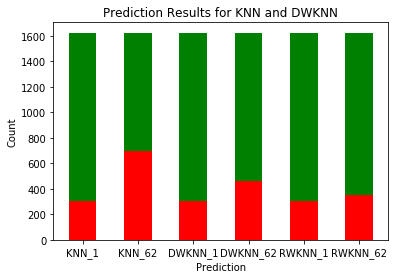

<Figure size 2160x2160 with 0 Axes>

In [32]:

KNN_kcomp1 = pd.read_csv('E3_KNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
KNN_kcomp1_results = KNN_kcomp1.groupby('prediction').count().data
count_correct_KNN_kcomp1 = (KNN_kcomp1_results.CORRECT)
count_wrong_KNN_kcomp1 = (KNN_kcomp1_results.WRONG)

DWKNN_kcomp1 = pd.read_csv('E3_DWKNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
DWKNN_kcomp1_results = DWKNN_kcomp1.groupby('prediction').count().data
count_correct_DWKNN_kcomp1 = (DWKNN_kcomp1_results.CORRECT)
count_wrong_DWKNN_kcomp1 = (DWKNN_kcomp1_results.WRONG)

RWKNN_kcomp1 = pd.read_csv('E3_RWKNN_T1_k1.csv')
#count number of CORRECT/ WRONG.
RWKNN_kcomp1_results = RWKNN_kcomp1.groupby('prediction').count().data
count_correct_RWKNN_kcomp1 = (RWKNN_kcomp1_results.CORRECT)
count_wrong_RWKNN_kcomp1 = (RWKNN_kcomp1_results.WRONG)

KNN_kcomp2 = pd.read_csv('E3_KNN_T1_k62.csv')
#count number of CORRECT/ WRONG.
KNN_kcomp2_results = KNN_kcomp2.groupby('prediction').count().data
count_correct_KNN_kcomp2 = (KNN_kcomp2_results.CORRECT)
count_wrong_KNN_kcomp2 = (KNN_kcomp2_results.WRONG)

RWKNN_kcomp2 = pd.read_csv('E3_RWKNN_T1_k62.csv')
#count number of CORRECT/ WRONG.
RWKNN_kcomp2_results = RWKNN_kcomp2.groupby('prediction').count().data
count_correct_RWKNN_kcomp2 = (RWKNN_kcomp2_results.CORRECT)
count_wrong_RWKNN_kcomp2 = (RWKNN_kcomp2_results.WRONG)

DWKNN_kcomp2 = pd.read_csv('E3_DWKNN_T1_k62.csv')
#count number of CORRECT/ WRONG.
DWKNN_kcomp2_results = DWKNN_kcomp2.groupby('prediction').count().data
count_correct_DWKNN_kcomp2 = (DWKNN_kcomp2_results.CORRECT)
count_wrong_DWKNN_kcomp2 = (DWKNN_kcomp2_results.WRONG)


# create plot
n_groups = 1 # number of groups
fig, ax = plt.subplots()
index = np.arange(n_groups) # x location for groups
bar_width = 1

#first bar - rects1+rects2
rects1 = plt.bar(index, count_correct_KNN_kcomp1, bar_width, bottom = count_wrong_KNN_kcomp1, 
#                  label='KNN_1_CORRECT', 
                 color = 'g')
rects2 = plt.bar(index, count_wrong_KNN_kcomp1, bar_width, 
                 color = 'r')

rects3 = plt.bar(index + 2*bar_width, count_correct_KNN_kcomp2, bar_width, bottom = count_wrong_KNN_kcomp2, 
                 color = 'g')
rects4 = plt.bar(index + 2*bar_width, count_wrong_KNN_kcomp2, bar_width, 
                 color = 'r')

rects5 = plt.bar(index + 4*bar_width, count_correct_DWKNN_kcomp1, bar_width, bottom = count_wrong_DWKNN_kcomp1, 
                 color = 'g')
rects6 = plt.bar(index + 4*bar_width, count_wrong_DWKNN_kcomp1, bar_width,
                 color = 'r')

rects7 = plt.bar(index + 6*bar_width, count_correct_DWKNN_kcomp2, bar_width, bottom = count_wrong_DWKNN_kcomp2,
                 color = 'g')
rects8 = plt.bar(index + 6*bar_width, count_wrong_DWKNN_kcomp2, bar_width,
                 color = 'r')

rects9 = plt.bar(index + 8*bar_width, count_correct_RWKNN_kcomp1, bar_width, bottom = count_wrong_RWKNN_kcomp1,  
                 color = 'g')
rects10 = plt.bar(index + 8*bar_width, count_wrong_RWKNN_kcomp1, bar_width, 
                 color = 'r')

rects9 = plt.bar(index + 10*bar_width, count_correct_RWKNN_kcomp2, bar_width, bottom = count_wrong_RWKNN_kcomp2,  
                 color = 'g')
rects10 = plt.bar(index + 10*bar_width, count_wrong_RWKNN_kcomp2, bar_width, 
                 color = 'r')

plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Prediction Results for KNN and DWKNN')
plt.xticks([0,2*bar_width, 4*bar_width, 6*bar_width, 8*bar_width, 10*bar_width], ["KNN_1", "KNN_62", "DWKNN_1", "DWKNN_62", "RWKNN_1", "RWKNN_62"])
# plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.figure(figsize=(30,30))
plt.show()

In [33]:
KNNsummary1 = KNN_kcomp1.groupby('prediction').count().data
RWKNNsummary1 = RWKNN_kcomp1.groupby('prediction').count().data
DWKNNsummary1 = DWKNN_kcomp1.groupby('prediction').count().data

KNNsummary2 = KNN_kcomp2.groupby('prediction').count().data
RWKNNsummary2 = RWKNN_kcomp2.groupby('prediction').count().data
DWKNNsummary2 = DWKNN_kcomp2.groupby('prediction').count().data

print("--------------")
print("Summary")
print("--------------")
print("KNNcomp1: \n", KNNsummary1)
print("Accuracy: ", KNN_kcomp1_results.CORRECT / 
      (KNN_kcomp1_results.CORRECT + KNN_kcomp1_results.WRONG))
print("\nKNNcomp2: \n", KNNsummary2)
print("Accuracy: ", KNN_kcomp2_results.CORRECT / 
      (KNN_kcomp2_results.CORRECT + KNN_kcomp2_results.WRONG))
print("--------------")
print("RWKNNcomp1: \n", RWKNNsummary1)
print("Accuracy: ", RWKNN_kcomp1_results.CORRECT / 
      (RWKNN_kcomp1_results.CORRECT + RWKNN_kcomp1_results.WRONG))
print("\nRWKNNcomp2: \n", RWKNNsummary2)
print("Accuracy: ", RWKNN_kcomp2_results.CORRECT / 
      (RWKNN_kcomp2_results.CORRECT + RWKNN_kcomp2_results.WRONG))
print("--------------")
print("DWKNNcomp1: \n", DWKNNsummary1)
print("Accuracy: ", DWKNN_kcomp1_results.CORRECT / 
      (DWKNN_kcomp1_results.CORRECT + DWKNN_kcomp1_results.WRONG))
print("\nDWKNNcomp2: \n", DWKNNsummary2)
print("Accuracy: ", DWKNN_kcomp2_results.CORRECT / 
      (DWKNN_kcomp2_results.CORRECT + DWKNN_kcomp2_results.WRONG))

--------------
Summary
--------------
KNNcomp1: 
 prediction
CORRECT    1318
WRONG       306
Name: data, dtype: int64
Accuracy:  0.8115763546798029

KNNcomp2: 
 prediction
CORRECT    924
WRONG      700
Name: data, dtype: int64
Accuracy:  0.5689655172413793
--------------
RWKNNcomp1: 
 prediction
CORRECT    1318
WRONG       306
Name: data, dtype: int64
Accuracy:  0.8115763546798029

RWKNNcomp2: 
 prediction
CORRECT    1275
WRONG       349
Name: data, dtype: int64
Accuracy:  0.7850985221674877
--------------
DWKNNcomp1: 
 prediction
CORRECT    1318
WRONG       306
Name: data, dtype: int64
Accuracy:  0.8115763546798029

DWKNNcomp2: 
 prediction
CORRECT    1163
WRONG       461
Name: data, dtype: int64
Accuracy:  0.7161330049261084


In [34]:
import re 

KNNtest1 = pd.read_csv('E3_KNN_T1_k1.csv')
voteResArray = KNNtest1['vote_result']
# print(KNNtest1.head())
KNNcomp1_errorSeries = []
for record in KNNtest1.values:
    voteRes = record[2]
    label = record[4]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    KNNcomp1_errorSeries.append(EDerror)

KNNtest2 = pd.read_csv('E3_KNN_T1_k62.csv')
voteResArray = KNNtest2['vote_result']
KNNcomp2_errorSeries = []
for record in KNNtest2.values:
    voteRes = record[2]
    label = record[4]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    KNNcomp2_errorSeries.append(EDerror)

RWKNNtest1 = pd.read_csv('E3_RWKNN_T1_k1.csv')
voteResArray = RWKNNtest1['vote_result']
# print(RWKNNtest1.head())
RWKNNcomp1_errorSeries = []
for record in RWKNNtest1.values:
    voteList = record[3][2:]
    voteRes = voteList[:voteList.find("'")]
#     print("VoteRES: ", voteRes)
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
#     print("labelRES: ", label)
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    RWKNNcomp1_errorSeries.append(EDerror)
    
RWKNNtest2 = pd.read_csv('E3_RWKNN_T1_k62.csv')
voteResArray = RWKNNtest2['vote_result']
# print(RWKNNtest2.head())
RWKNNcomp2_errorSeries = []
for record in RWKNNtest2.values:
    voteList = record[3][2:]
    voteRes = voteList[:voteList.find("'")]
#     print("VoteRES: ", voteRes)
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
#     print("labelRES: ", label)
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    RWKNNcomp2_errorSeries.append(EDerror)
    
DWKNNtest1 = pd.read_csv('E3_DWKNN_T1_k1.csv')
voteResArray = DWKNNtest1['vote_result']
DWKNNcomp1_errorSeries = []
for record in DWKNNtest1.values:
    voteRes = record[3]
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    DWKNNcomp1_errorSeries.append(EDerror)   
    
DWKNNtest2 = pd.read_csv('E3_DWKNN_T1_k62.csv')
voteResArray = DWKNNtest2['vote_result']
DWKNNcomp2_errorSeries = []
for record in DWKNNtest2.values:
    voteRes = record[3]
    labelList = record[2][2:]
    label = labelList[:labelList.find("'")]
    voteTuple = tuple(map(int, voteRes.split(',')))
    labelTuple = tuple(map(int, label.split(',')))
    EDerror = euclideanDistance(voteTuple, labelTuple)
#     print(euclideanDistance(voteTuple, labelTuple))
    DWKNNcomp2_errorSeries.append(EDerror) 

    
# =================== #
errorDataframe = pd.DataFrame(index = range(0,len(KNNtest1)))
errorDataframe['KNNcomp1'] = KNNcomp1_errorSeries
errorDataframe['KNNcomp2'] = KNNcomp2_errorSeries
errorDataframe['RWKNNcomp1'] = RWKNNcomp1_errorSeries
errorDataframe['RWKNNcomp2'] = RWKNNcomp2_errorSeries
errorDataframe['DWKNNcomp1'] = DWKNNcomp1_errorSeries
errorDataframe['DWKNNcomp2'] = DWKNNcomp1_errorSeries
errorDataframe


,KNNcomp1,KNNcomp2,RWKNNcomp1,RWKNNcomp2,DWKNNcomp1,DWKNNcomp2
0,0.0,6.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,6.0,6.0,6.0,6.0,6.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1619,0.0,0.0,0.0,0.0,0.0,0.0
1620,12.0,0.0,12.0,0.0,12.0,12.0
1621,0.0,6.0,0.0,0.0,0.0,0.0
1622,0.0,0.0,0.0,0.0,0.0,0.0


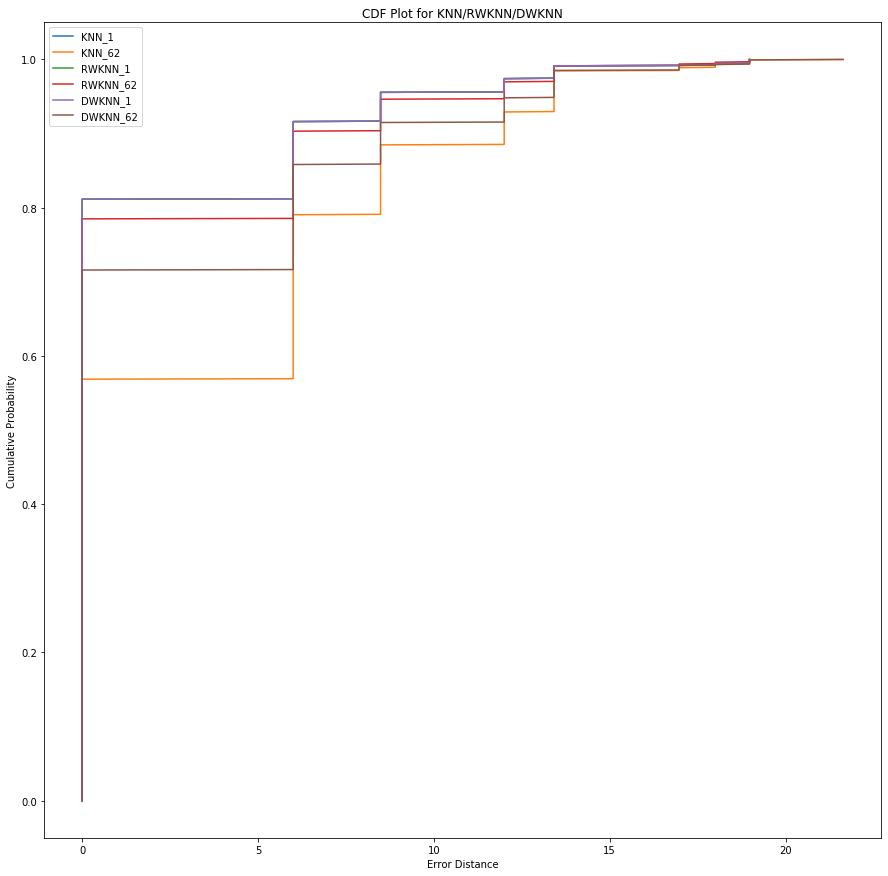

<Figure size 432x288 with 0 Axes>

In [35]:
fig= plt.figure(figsize=(15,15))
errorCDFPlot = ('E'+str(exp)+'_errorCDFPlot_T'+str(trial)+'.png')
knn_kcomp1_error = np.sort(KNNcomp1_errorSeries)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")

knn_kcomp2_error = np.sort(KNNcomp2_errorSeries)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
plt.plot(knn_kcomp2_error,cdf, label = "KNN_62")

rwknn_kcomp1_error = np.sort(RWKNNcomp1_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp1_error),step=1)/(len(rwknn_kcomp1_error)-1)
plt.plot(rwknn_kcomp1_error,cdf, label = "RWKNN_1")

rwknn_kcomp2_error = np.sort(RWKNNcomp2_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp2_error),step=1)/(len(rwknn_kcomp2_error)-1)
plt.plot(rwknn_kcomp2_error,cdf, label = "RWKNN_62")

dwknn_kcomp1_error = np.sort(DWKNNcomp1_errorSeries)
cdf = np.arange(0,len(rwknn_kcomp1_error),step=1)/(len(rwknn_kcomp1_error)-1)
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")

dwknn_kcomp2_error = np.sort(DWKNNcomp2_errorSeries)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_62")

plt.legend()
plt.title('CDF Plot for KNN/RWKNN/DWKNN')
plt.xlabel('Error Distance')
plt.ylabel('Cumulative Probability')
plt.show()
plt.savefig(errorCDFPlot)

Median Error:
KNNcomp1      0.0
KNNcomp2      0.0
RWKNNcomp1    0.0
RWKNNcomp2    0.0
DWKNNcomp1    0.0
DWKNNcomp2    0.0
dtype: float64

0.75 Quantile Error:
KNNcomp1      0.0
KNNcomp2      6.0
RWKNNcomp1    0.0
RWKNNcomp2    0.0
DWKNNcomp1    0.0
DWKNNcomp2    0.0
Name: 0.75, dtype: float64

Max Error:
KNNcomp1      18.973666
KNNcomp2      21.633308
RWKNNcomp1    18.973666
RWKNNcomp2    18.973666
DWKNNcomp1    18.973666
DWKNNcomp2    18.973666
dtype: float64

Std Error:
KNNcomp1      3.586912
KNNcomp2      4.763841
RWKNNcomp1    3.586912
RWKNNcomp2    3.769612
DWKNNcomp1    3.586912
DWKNNcomp2    3.586912
dtype: float64


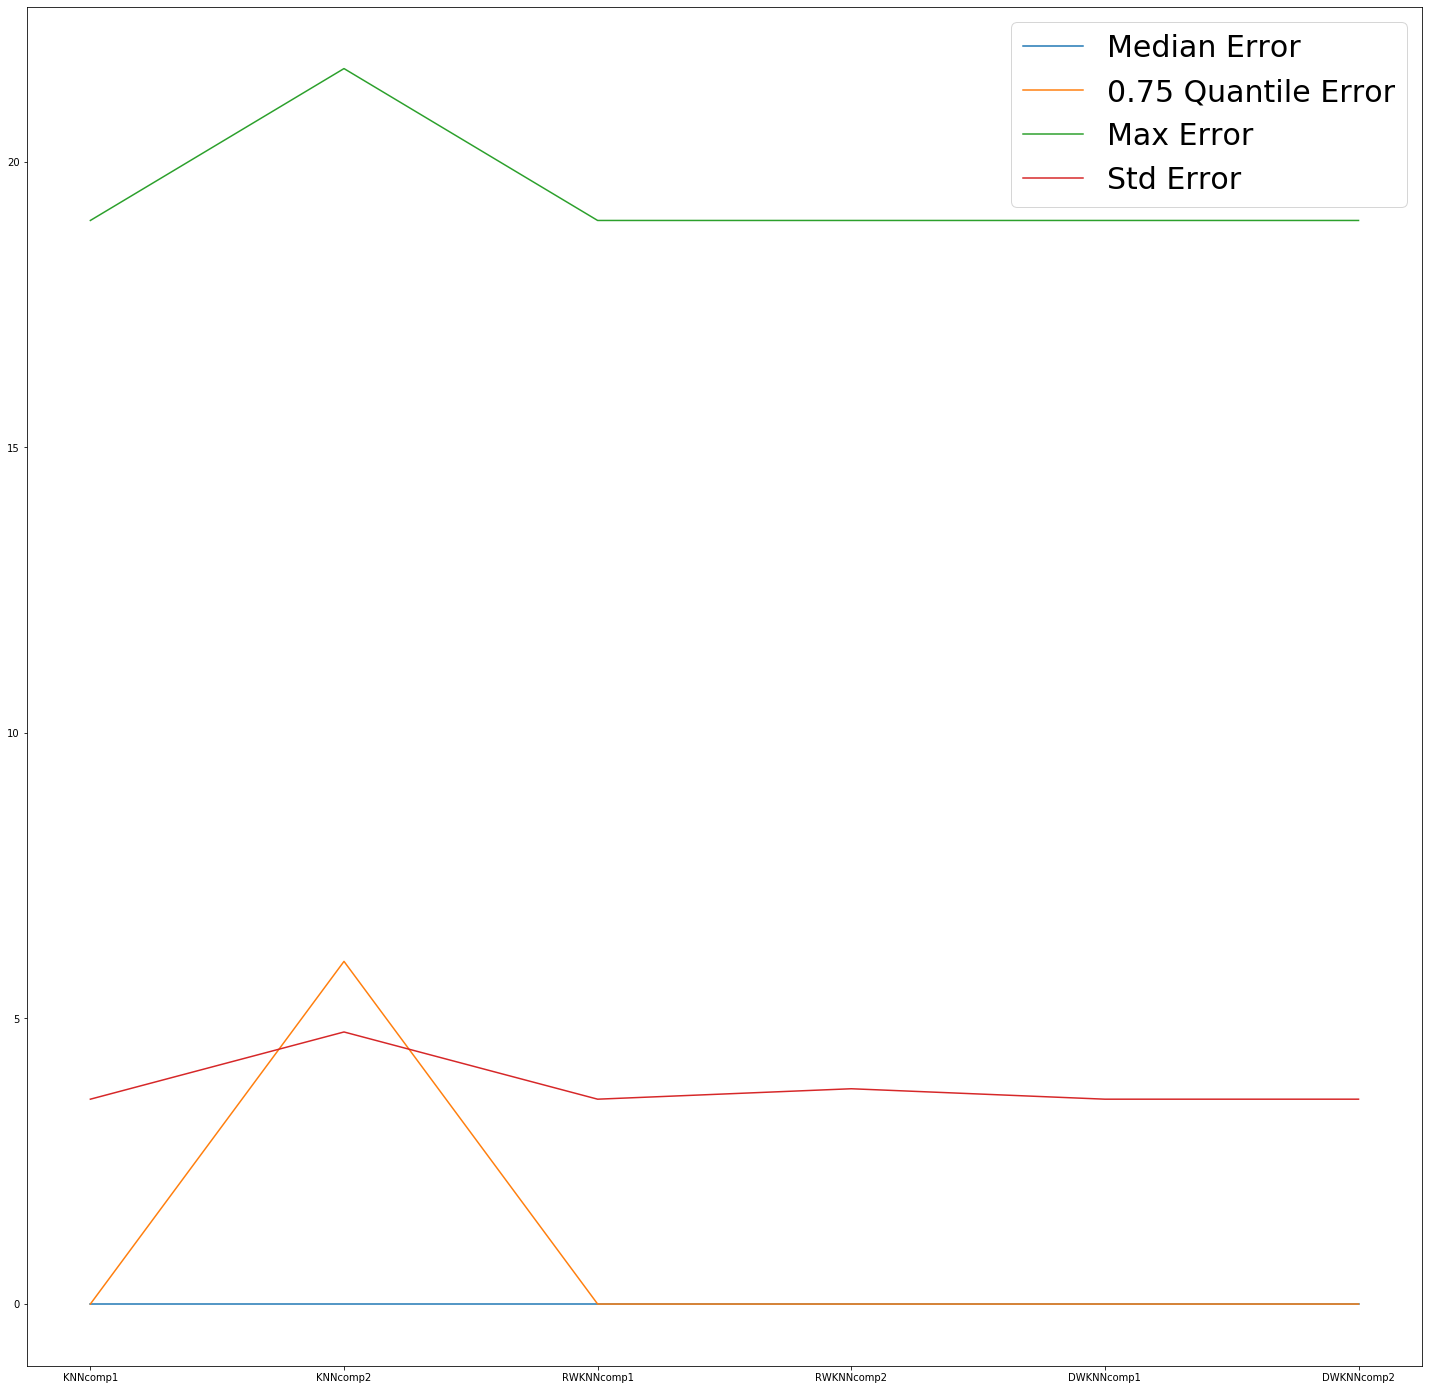

In [37]:
plt.figure(figsize = (25,25))
errorDf = errorDataframe


errorLine = ('E'+str(exp)+'_errorLine_T'+str(trial)+'.png')
print("Median Error:")
print(errorDf.median())
plt.plot(errorDf.median(), label = "Median Error")

print("\n0.75 Quantile Error:")
print(errorDf.quantile(0.75))
plt.plot(errorDf.quantile(0.75), label = "0.75 Quantile Error")
print("\nMax Error:")
print(errorDf.max())
plt.plot(errorDf.max(), label = "Max Error")

print("\nStd Error:")
print(errorDf.std())
plt.plot(errorDf.std(), label = "Std Error")

plt.legend(loc = 'best', fontsize = 30)
plt.savefig(errorLine)

In [41]:
# Create Error File
kvalList = [1, 62]
writeErrSumm = True
fileNameErrSumm = ('E'+str(exp)+'_ErrSummary_T'+str(trial)+'.csv')
meanErrArr = []
medianErrArr = []
quantErrArr = []
maxErrArr = []
stdDevArr = []
for series in errorDf:
    meanErrArr.append(errorDf[series].mean())
    medianErrArr.append(errorDf[series].median())
    quantErrArr.append(errorDf[series].quantile(0.75))
    maxErrArr.append(errorDf[series].max())
    stdDevArr.append(errorDf[series].std())
    
errorSummary = pd.DataFrame(index=range(0,len(errorDf.columns)))
errorSummary.insert(loc=0, column="Mean Error", value=meanErrArr)
errorSummary.insert(loc=1, column="Median Error", value=medianErrArr)
errorSummary.insert(loc=2, column="0.75 Quantile Error", value=quantErrArr)
errorSummary.insert(loc=3, column="Max Error", value=maxErrArr)
errorSummary.insert(loc=4, column="Std Error", value=stdDevArr)
algoType = ["knn_k"+str(kvalList[0]), "knn_k"+str(kvalList[1]), "rwknn_k"+str(kvalList[0]), "rwknn_k"+str(kvalList[1]),
                "dwknn_k"+str(kvalList[0]), "dwknn_k"+str(kvalList[1])]

errorSummary.insert(loc=0, column="Algorithm", value = algoType)
print(errorSummary)


if (writeErrSumm == True):
    errorSummary.to_csv(fileNameErrSumm, index=False)
    print("File "+fileNameErrSumm+" has been written.")
# print(medianErrArr)

   Algorithm  Mean Error  Median Error  0.75 Quantile Error  Max Error  \
0     knn_k1    1.575401           0.0                  0.0  18.973666   
1    knn_k62    3.685892           0.0                  6.0  21.633308   
2   rwknn_k1    1.575401           0.0                  0.0  18.973666   
3  rwknn_k62    1.801274           0.0                  0.0  18.973666   
4   dwknn_k1    1.575401           0.0                  0.0  18.973666   
5  dwknn_k62    1.575401           0.0                  0.0  18.973666   

   Std Error  
0   3.586912  
1   4.763841  
2   3.586912  
3   3.769612  
4   3.586912  
5   3.586912  
File E3_ErrSummary_T1.csv has been written.


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

temp = errorSummary['Algorithm']
errorSummary = errorSummary.reset_index()
errorSummary = errorSummary.drop(columns=['Algorithm'])
errorSummary.index = temp
errorSummary = errorSummary.drop(columns=['index'])
errorSummary


,Mean Error,Median Error,0.75 Quantile Error,Max Error,Std Error
Algorithm,,,,,
knn_k1,1.575401,0.0,0.0,18.973666,3.586912
knn_k62,3.685892,0.0,6.0,21.633308,4.763841
rwknn_k1,1.575401,0.0,0.0,18.973666,3.586912
rwknn_k62,1.801274,0.0,0.0,18.973666,3.769612
dwknn_k1,1.575401,0.0,0.0,18.973666,3.586912
dwknn_k62,1.575401,0.0,0.0,18.973666,3.586912


<Figure size 432x288 with 0 Axes>

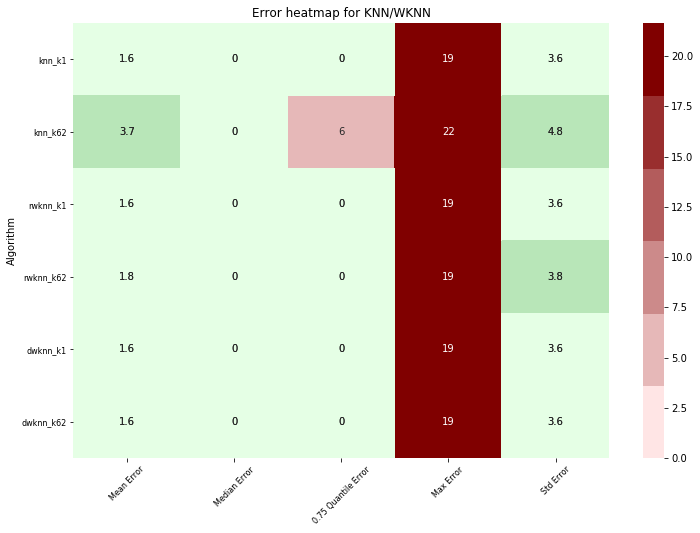

In [43]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
figName = ('E'+str(exp)+'_errorHeatMap_T'+str(trial)+'.png')
fig = plt.figure(facecolor='w', edgecolor='k')
fig =plt.figure(figsize=(12,8))
ax = plt.axes()
g = sns.heatmap(errorSummary, annot=True, cmap =sns.light_palette('maroon'))
sns.heatmap(errorSummary, mask= errorSummary > 5, annot=True, cmap=sns.light_palette('green'), cbar=False,
                ax = ax)
ax.set_title('Error heatmap for KNN/WKNN')
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 8)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
plt.savefig(figName)